<a href="https://colab.research.google.com/github/ntontonto/kaggle/blob/mitty_branch/Sprint7_selectKbest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle用データのインポート

In [1]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rmkenshirou","key":"e460ce0d323c2eed67441cce23eb3978"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 19.9MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_description.txt    
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


## ライブラリのインポート

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics

## データのダウンロード

In [72]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

In [73]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## 欠損値の確認



In [74]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False) ## すべてのデータフレームの要素をnullではなくして，カウントしているため，全体の欠損値の割合を示している。
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


### sale priceの散布図

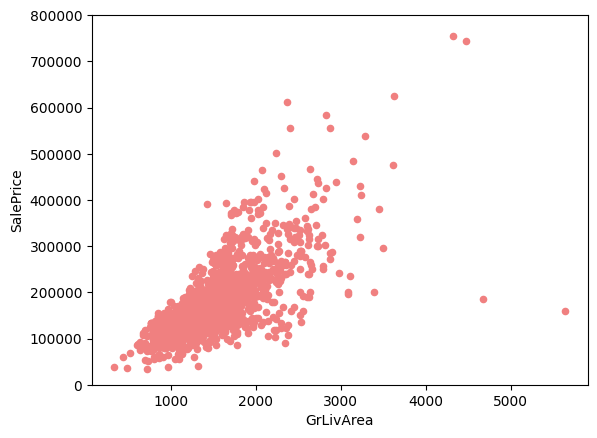

In [75]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

## 一旦横の2つ外れ値を消す（外れ値の消去）
- あとで考察する，時間があれば

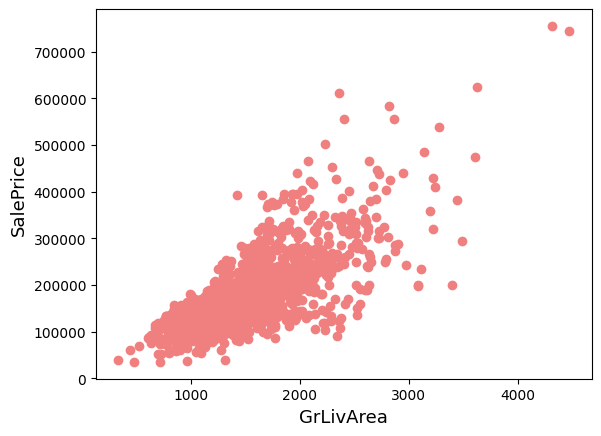

In [76]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#### 横二つが消えていることが確認できた

Skewness : 1.0109917025385513
Kurtosis : 2.063463404376057


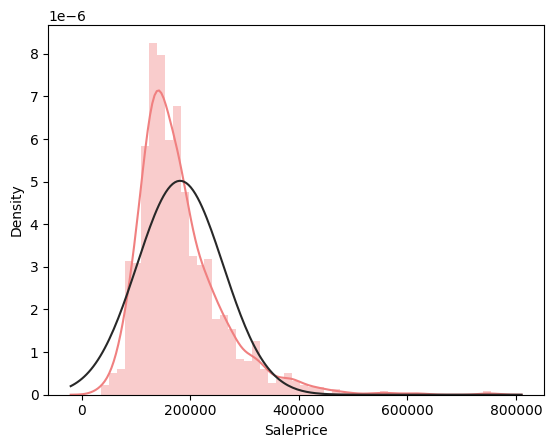

In [77]:
sns.distplot(train['SalePrice'] , fit=norm);
print("Skewness :", train[var].skew())
print("Kurtosis :", train[var].kurt())

### 歪度，尖度について
- 歪度（skewness）：値が正であれば分布が右に伸びている
- 尖度(Kurtosis) : 正規分布を基準とした分布の鋭さの指標。正規分布の尖度を0と定義する場合と3と定義する場合がある。基準である正規分布の尖度よりも大きければ分布は尖っており、小さければ緩やかな分布である。<br><br>
Skewness : 1.0109917025385513<br>
Kurtosis : 2.063463404376057<br>
であることから，分布は右に伸びており，分布はとがっていることが分かる．

### logによる後処理
- log(x + 1)を施す


 mu = 12.02 and sigma = 0.40



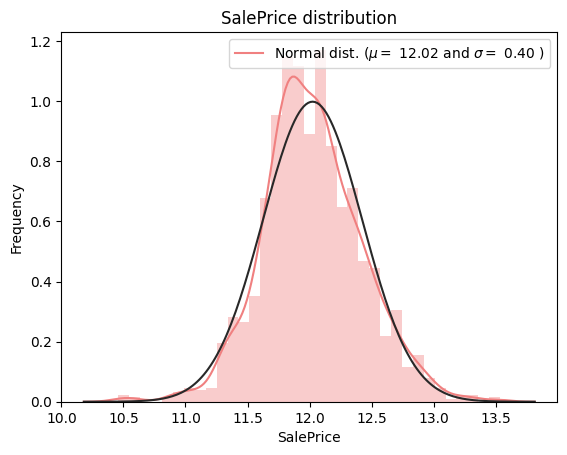

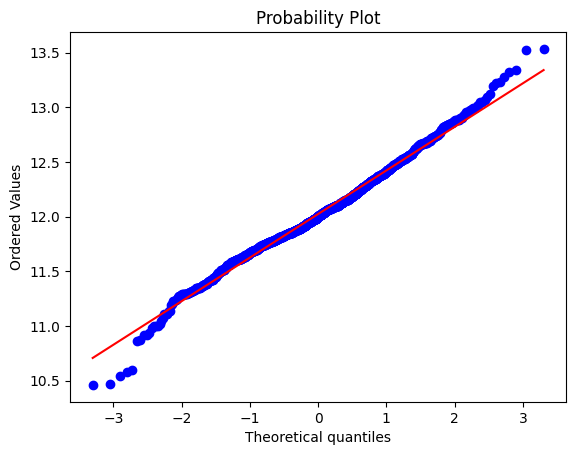

In [78]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [79]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [80]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = all_data.drop(['SalePrice'], axis = 1)

In [81]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### str cast

In [82]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [83]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 79)


In [84]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


### 歪度が0.75以上のものはBOXCOX

In [85]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [86]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 221)


In [87]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
        train.values, y_train, test_size=0.2, random_state=0)

In [56]:
train['MSZoning'] = train.MSZoning.astype(str)

In [96]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse), model

## modeling

In [101]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [97]:
score, model = rmsle_cv(model)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

In [102]:
importance_df = pd.DataFrame(model.feature_importances_, index = train[train.columns[train.columns != "SalePrice"]].columns, columns = ["importance"])
importance_df = importance_df.sort_values("importance", ascending = False)
# importance_df["importance"] = importance_df["importance"]*100/importance_df["importance"].max()
importance_df.head(20)

,importance
Id,184
GarageArea,154
GrLivArea,114
TotalBsmtSF,108
BsmtUnfSF,105
LotArea,100
BsmtFinSF1,96
1stFlrSF,95
LotFrontage,93
OpenPorchSF,88


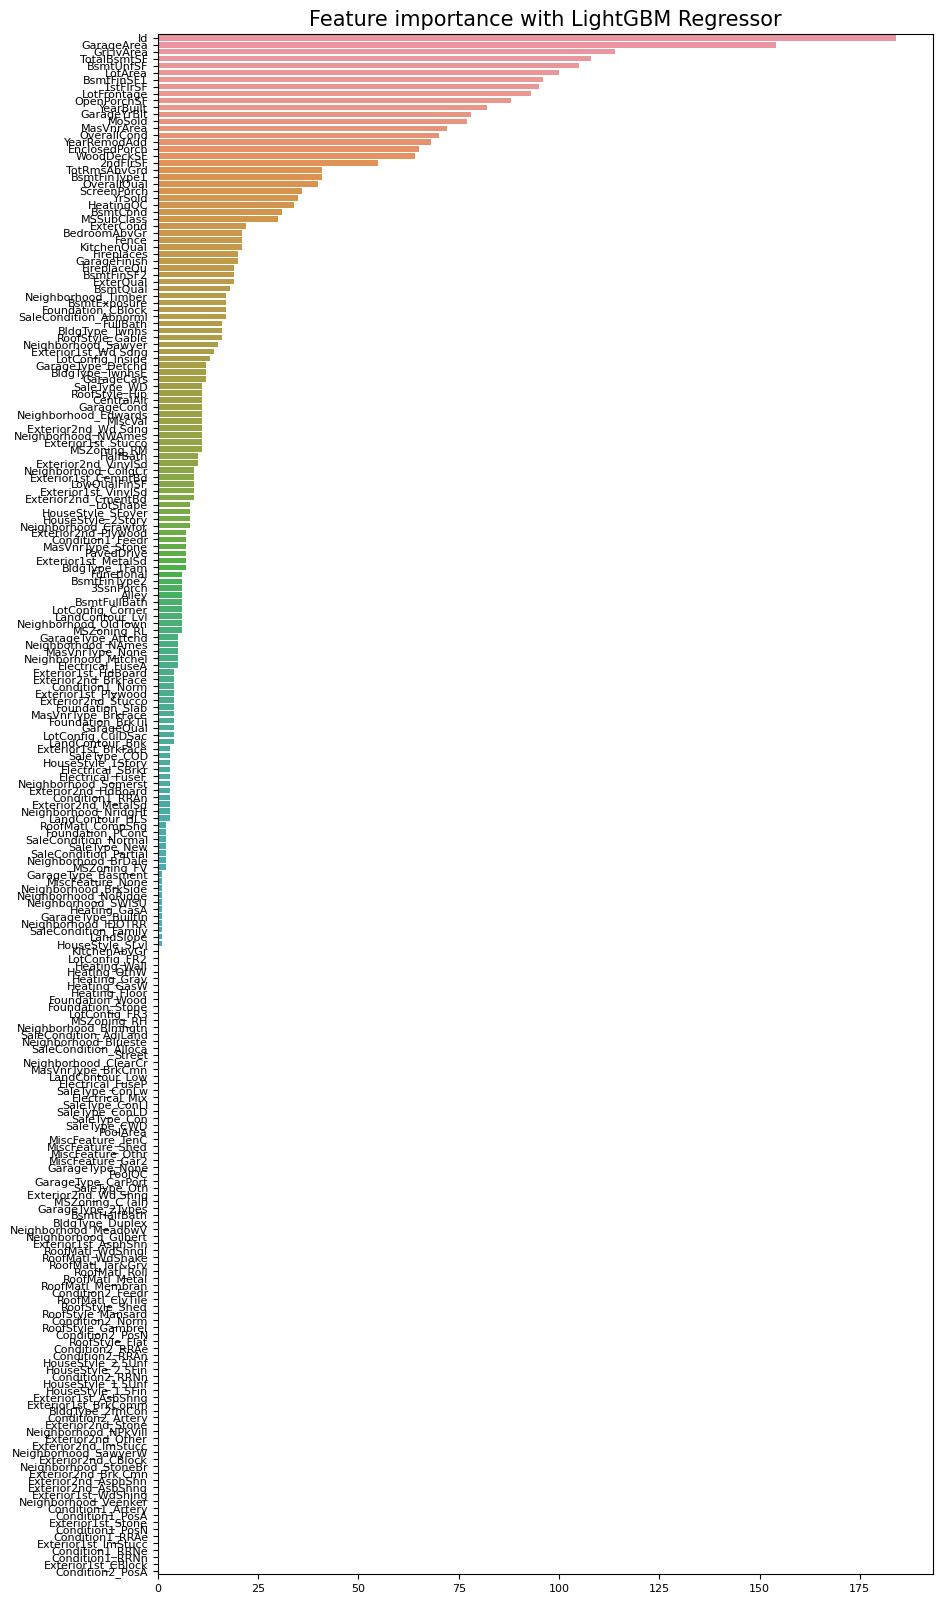

In [107]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y=importance_df.index, data=importance_df)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.title('Feature importance with LightGBM Regressor', size=15)

plt.show()

# データの概形確認

## 欠損値の確認

<Axes: >

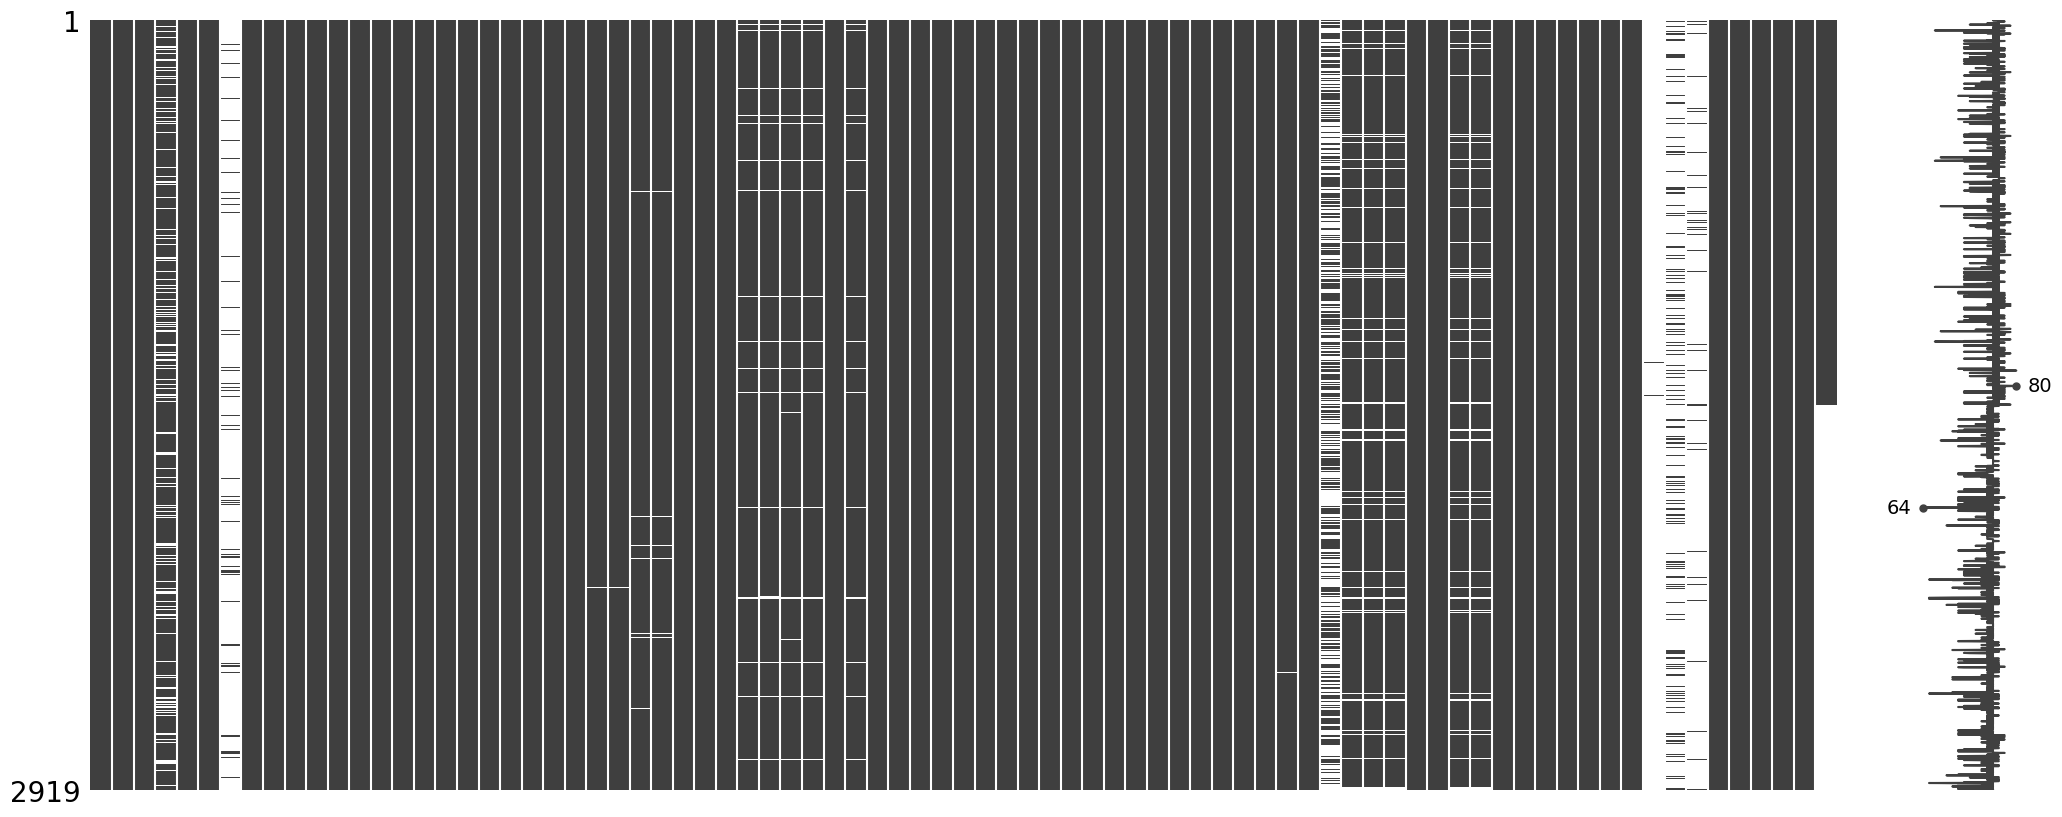

In [ ]:
import missingno as msno
msno.matrix(all_data)

<Axes: >

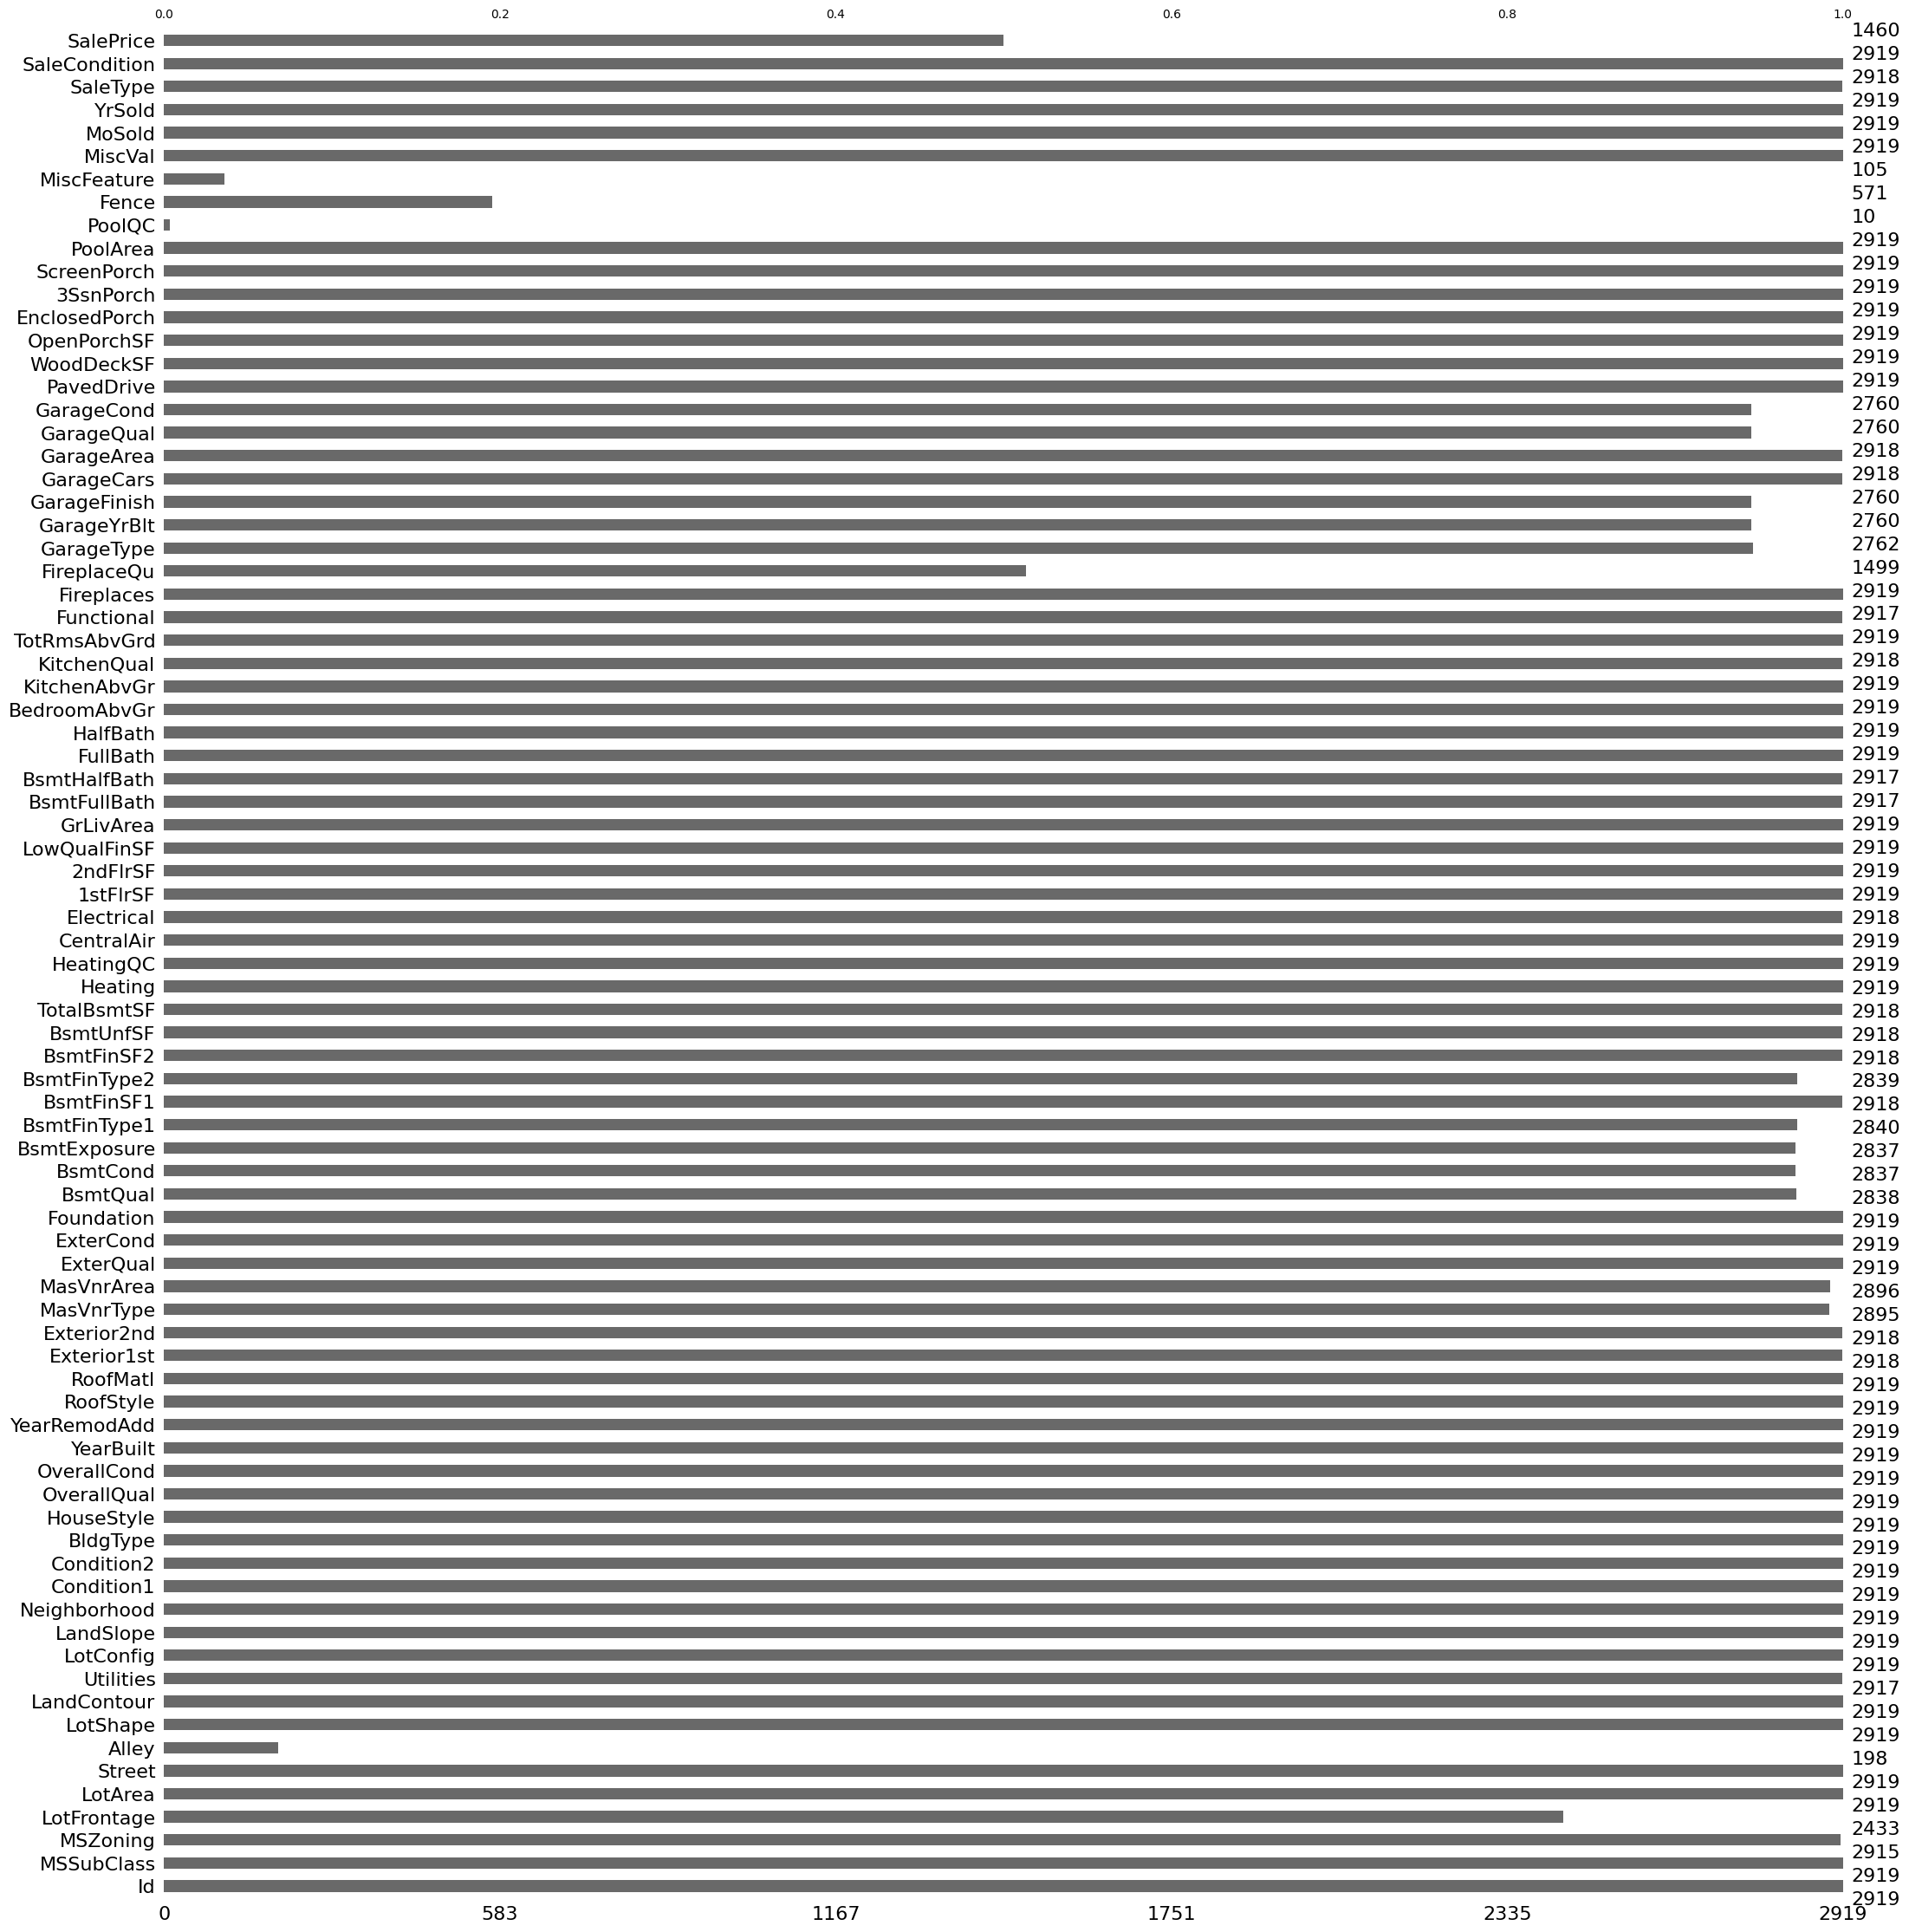

In [ ]:
msno.bar(all_data)

## 欠損値に対する処理 ⇒ dropna()するとかなり行数が減るので今回は残す
- 欠損値のまま取り扱う：「何らかの理由で欠損している」という情報を残す。欠損値を扱えないライブラリを利用する場合には、-9999党のあり得ない値を入れたりする
- 代表値で埋める
  - 平均値
  - 中央値
  - 対数変換などにより歪みの少ない分布にしてから平均をとる
  - グループごとの平均値をとり、その値を入力する
  - Bayesian average
  - 欠損値を目的変数として予測し、予測した値を入力する

## 分布の確認

#### Target の確認(Dependent, Nominal)
- paveの方が分布は広いが，かといってsalepriceに因果関係にあるとは断言しづらい

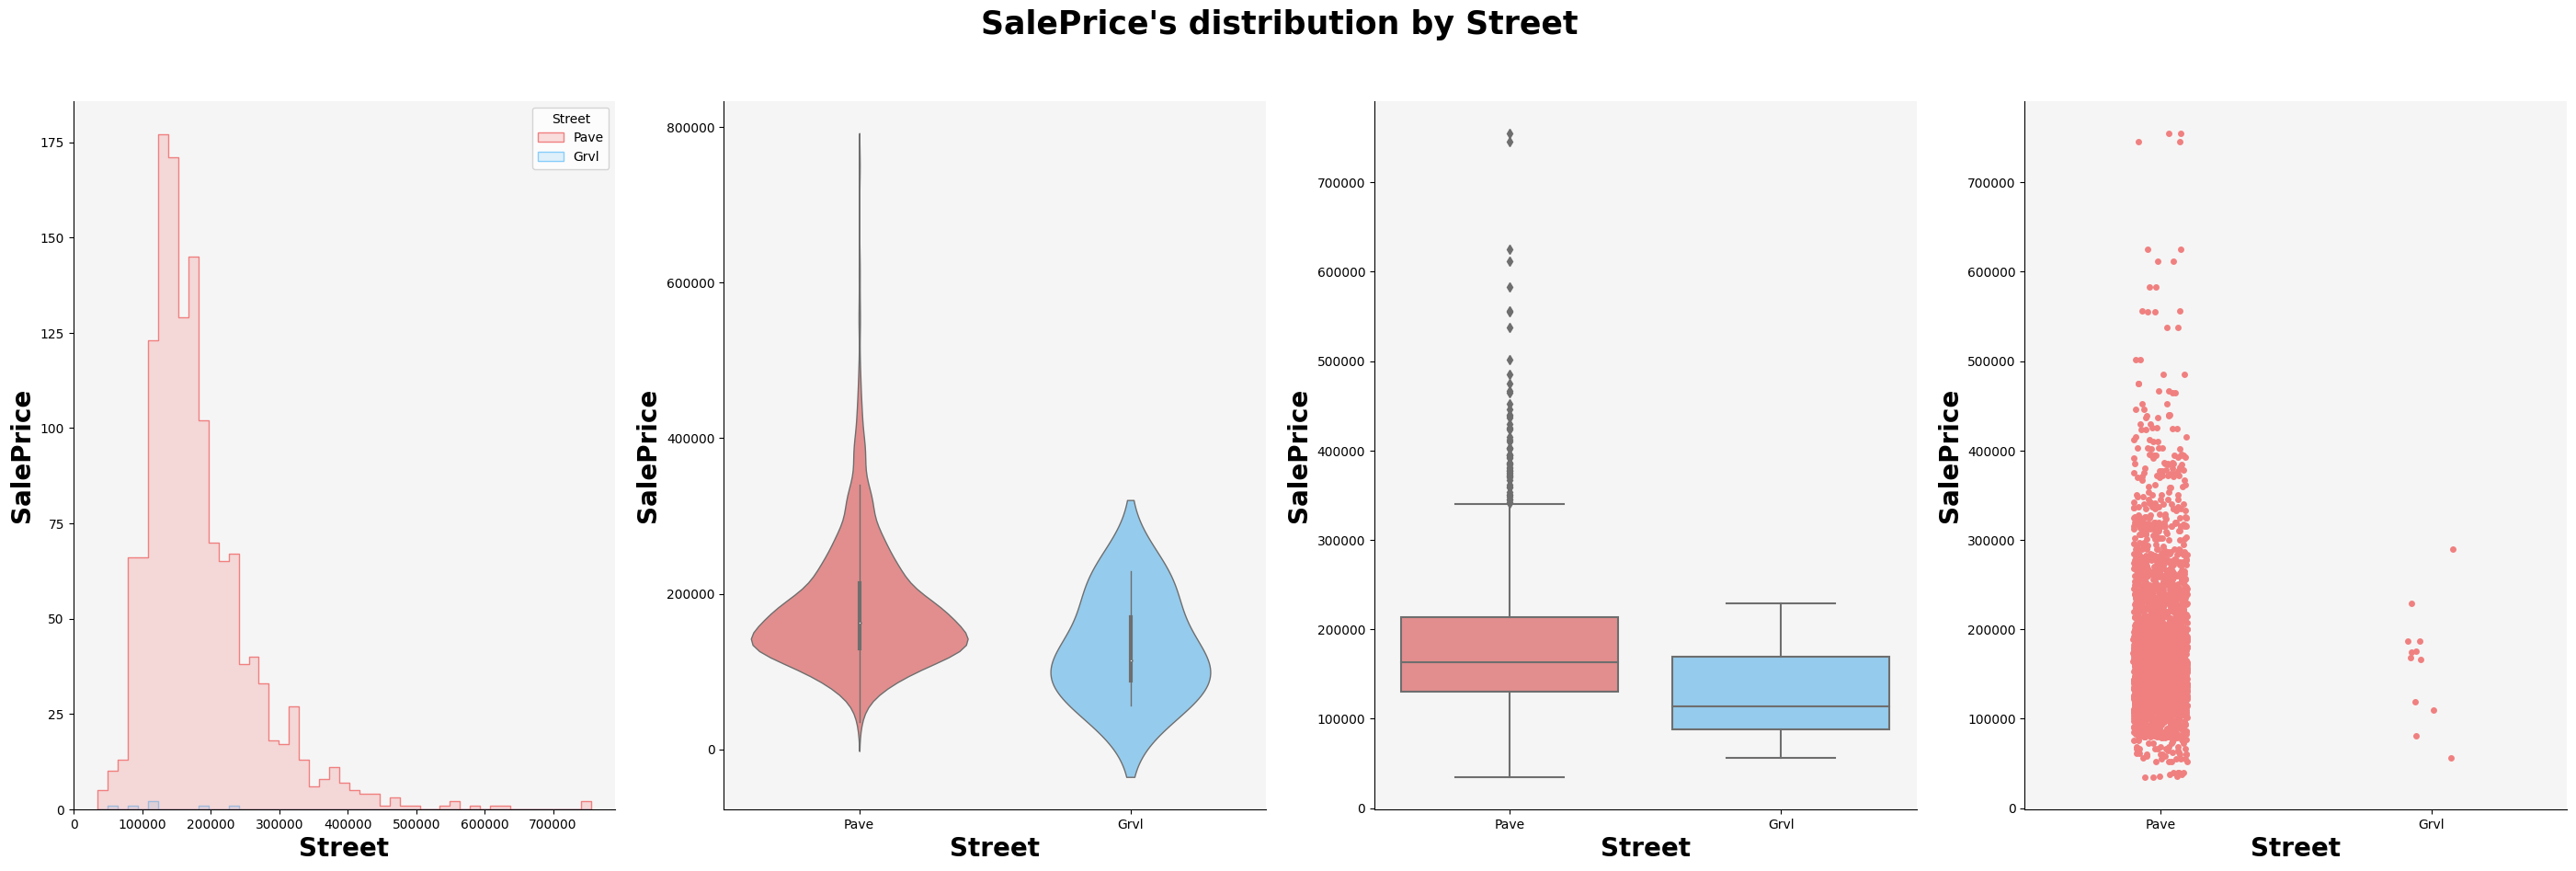

In [ ]:
continuous_dist(all_data, "Street", "SalePrice")

In [ ]:
sns.set()
cols = numerical_cols
sns.pairplot(train[cols], size = 2.5,dropna=True)
plt.show();

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f2fec499700> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f2fec50c940> (for post_execute):


KeyboardInterrupt: ignored

### 各データの分布（数値）

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>],
       [<Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'Kitc

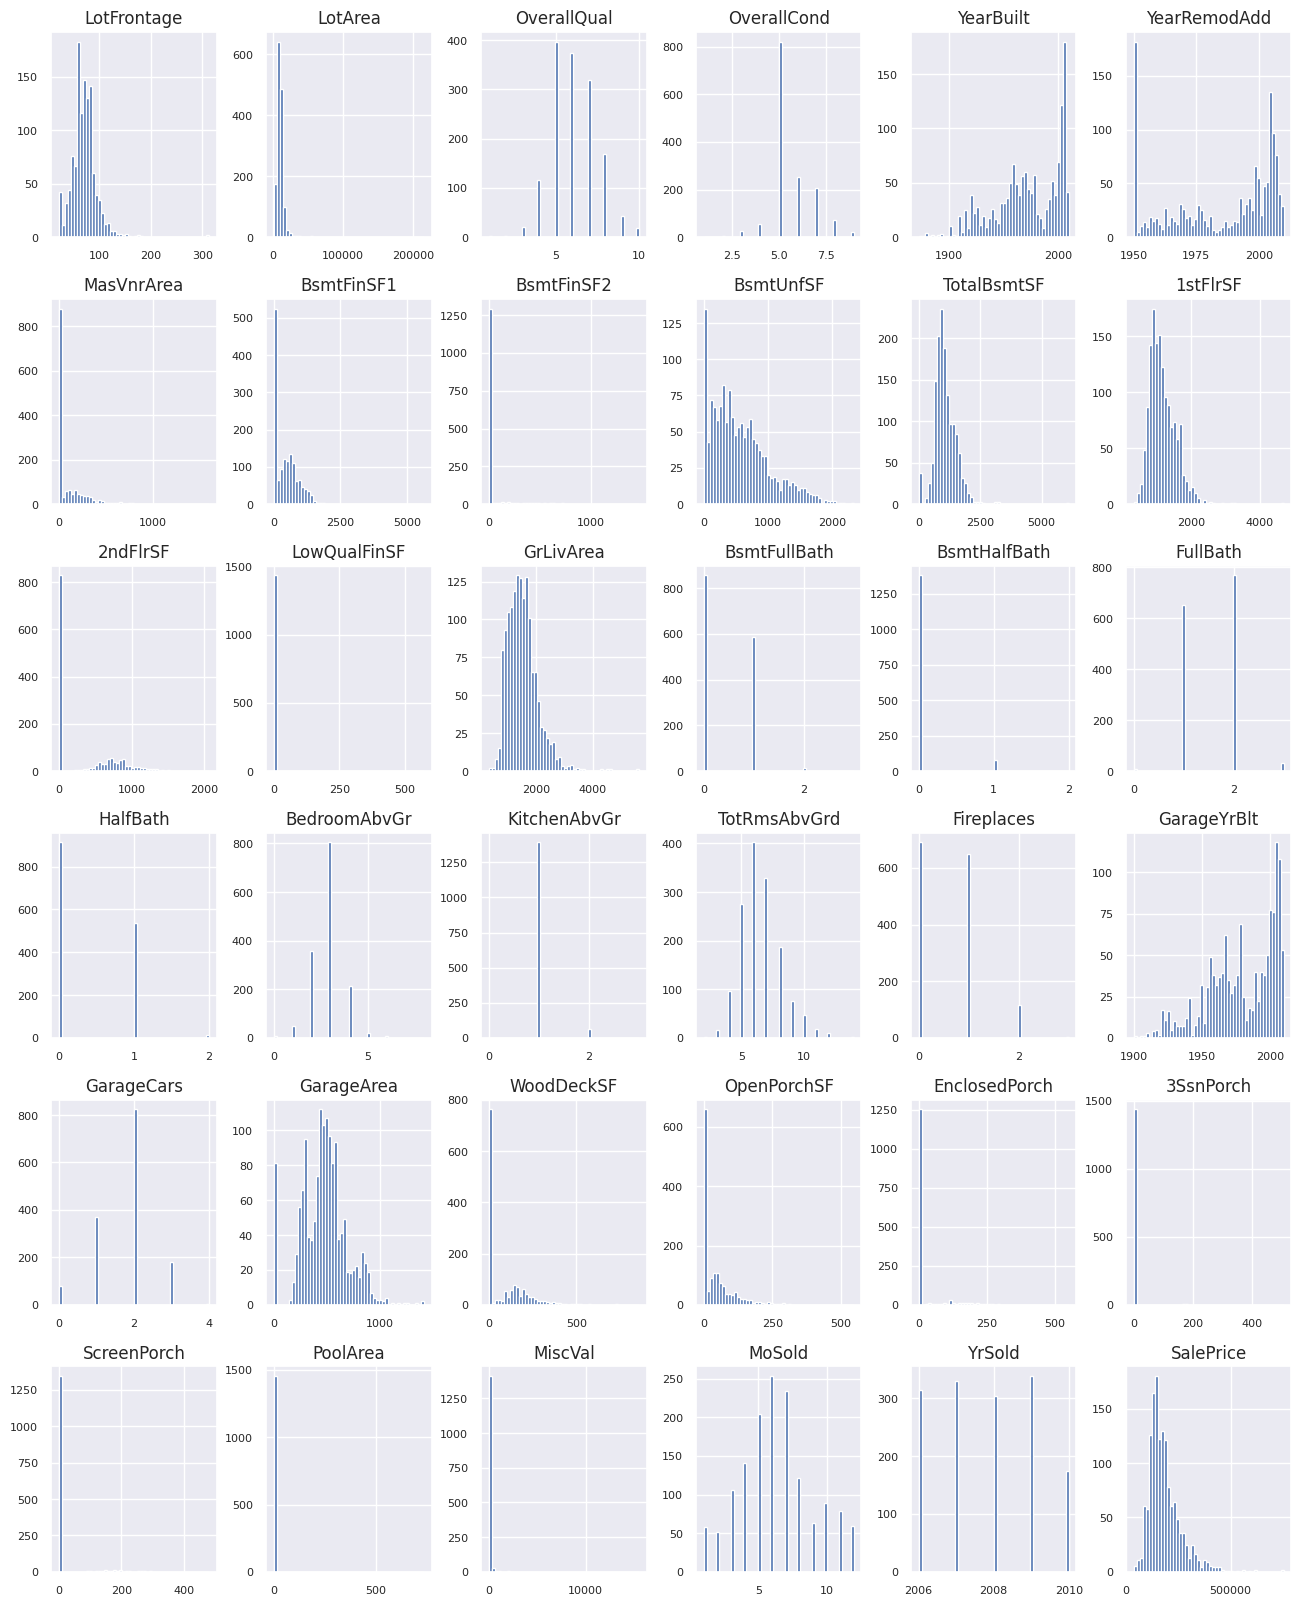

In [ ]:
train[cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

ValueError: ignored

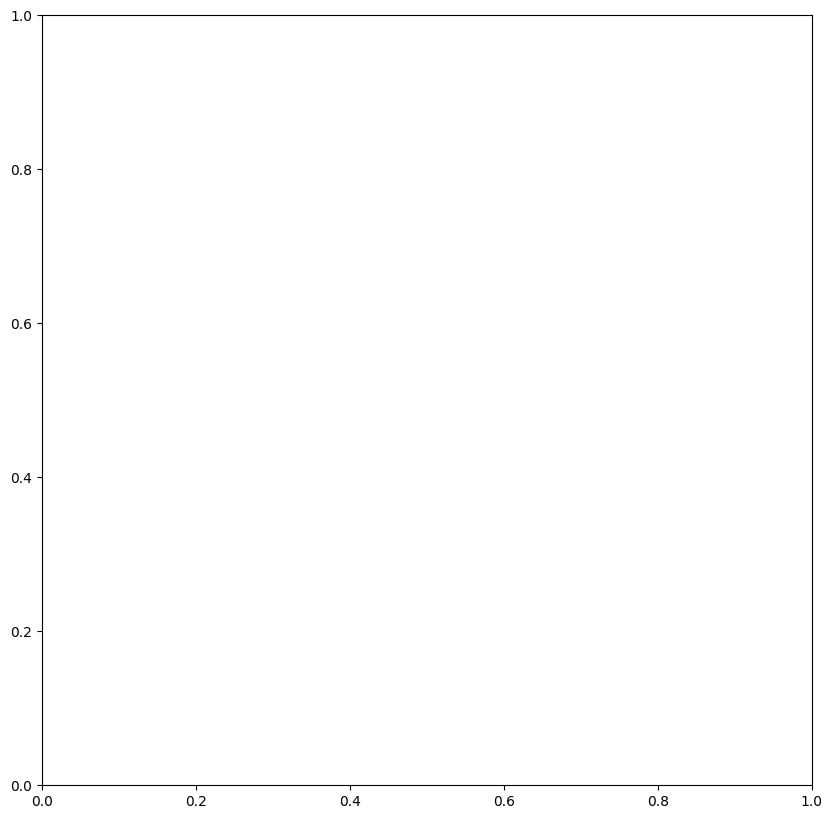

In [ ]:
plt.subplots(figsize=(25, 10))
plt.pie(train.SalePrice.value_counts(), shadow=True, explode=[.03,.03], autopct='%1.1f%%', textprops={'fontsize': 20, 'color': 'white'})
plt.title('SalePrice Distribution', size=20)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

### 量的変数

#### Age (Continuous)

In [ ]:
continuous_dist(train, 'Transported', 'Age')
permutation_test(train, 'Transported', 'Age')

#### Age binning

In [ ]:
tmp = train.copy()
tmp['AgeBin'] = 7
for i in range(6):
    tmp.loc[(tmp.Age >= 10*i) & (tmp.Age < 10*(i + 1)), 'AgeBin'] = i
cat_dist(tmp, var='AgeBin', hue='Transported', msg_show=False)

NameError: ignored

#### その他のContinuous

In [ ]:
# logy引数により対数プロットにしている
for col in continuous_vars:
  all_data[col].plot(kind='hist', logy=True)
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.show()

In [ ]:
sns.set()
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', "CryoSleep"]
sns.pairplot(train[cols], hue="CryoSleep", size = 2.5,dropna=True)
plt.show();

NameError: ignored

### カテゴリ変数

#### HomePlanet (Nominal)

In [ ]:
# unique が多すぎる変数に対して実行すると busy になってしまうので注意
cat_dist(train, var='HomePlanet', hue='Transported')
display(train.pivot_table(index="HomePlanet", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(train, "HomePlanet", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

#### Destination (Nominal)

In [ ]:
# unique が多すぎる変数に対して実行すると busy になってしまうので注意
cat_dist(train, var='Destination', hue='Transported')
display(train.pivot_table(index="Destination", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(train, "Destination", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

#### Cabin

In [ ]:
tmp = train.copy()
tmp['Deck'] = train.Cabin.apply(lambda x:str(x)[:1])
tmp['side'] = train.Cabin.apply(lambda x:str(x)[-1:])

#### Deck (Nominal)

In [ ]:
cat_dist(tmp, var='Deck', hue='Transported')
display(tmp.pivot_table(index="Deck", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
anova_perm(tmp, "Deck", "Transported", logx=False) # 群が3つ以上なので、ANOVAを利用する

NameError: ignored

#### Side (Nominal, Binary)

In [ ]:
cat_dist(tmp, var='side', hue='Transported')
display(tmp.pivot_table(index="side", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(tmp, 'side', "Transported")

#### CryoSleep (Nominal, binary)

In [ ]:
cat_dist(train, var='CryoSleep', hue='Transported')
display(train.pivot_table(index="CryoSleep", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(train, 'CryoSleep', "Transported")

#### VIP (Nominal, Binary)

In [ ]:
cat_dist(train, var='VIP', hue='Transported')
display(train.pivot_table(index="VIP", values="Transported", aggfunc=['count', 'sum', 'mean']).style.background_gradient(vmin=0))
permutation_test(train, 'VIP', "Transported")

### Multinomial Explore

#### HomePlanet and CryoSleep

In [ ]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='CryoSleep', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and CryoSleep', weight='bold', size=15)
g.set_xlabel('CryoSleep', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

#### HomePlanet and Destination

In [ ]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='HomePlanet', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by HomePlanet and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('HomePlanet', weight='bold', size=13)
plt.show()

pd.crosstab([train.Destination, train.Transported], train.HomePlanet,margins=True).style.background_gradient()

#### CryoSleep and Destination

In [ ]:
plt.subplots(figsize=(10, 5))
g = sns.heatmap(train.pivot_table(index='CryoSleep', columns='Destination', values='Transported'), annot=True, cmap="YlGnBu")
g.set_title('Transported ratio by CryoSleep and Destination', weight='bold', size=15)
g.set_xlabel('Destination', weight='bold', size=13)
g.set_ylabel('CryoSleep', weight='bold', size=13)
plt.show()

pd.crosstab([train.CryoSleep, train.Transported], train.Destination,margins=True).style.background_gradient()

NameError: ignored

# 分析の方針決め

### 分析前の仮説
- 分析の軸をブレストする
- 方針を決める
- 担当者を決める
- 「確認すること（担当者）」のフォーマットでこのセルにメモをする

# 分析
- 統計検定のコードは、「static_analysys.ipynb」を参照
- 特殊なグラフ化のコードは「visualization_templete.ipynb」を参照

## 確認すること1（担当者）：結果

## 確認すること2（担当者）：結果

### 欠損値への対処
- 消費したお金
  - 仮死状態にあれば、お金は消費していないのでは？
  - 仮死状態にない場合には、属性に応じたそれっぽい値を入れる

In [ ]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

#### TotalSpend

##### CryoSleep＝Trueの場合

In [ ]:
# 仮死状態を選択している場合には、消費金額はゼロ
all_data[all_data['CryoSleep']==True]['TotalSpend'].describe()

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']==True) & (all_data[col].isna()), col] = 0
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

##### CryoSleep＝Falseの場合

In [ ]:
# 割とばらつきがある
all_data[all_data['CryoSleep']==False]['TotalSpend'].describe()

In [ ]:
plt.scatter(all_data[all_data['CryoSleep']==False]['Age'], all_data[all_data['CryoSleep']==False]['TotalSpend'])

In [ ]:
# 12歳以下の場合にはTotalSpendは0
for age in np.sort(all_data['Age'].unique()):
  data = all_data[all_data['Age']==age]['TotalSpend']
  print(f"age: {age}, min: {data.min()}, mean: {data.mean()}, max: {data.max()}")

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']<13) & (all_data[col].isna()), col] = 0

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

In [ ]:
all_data.isna().sum()

In [ ]:
all_data.loc[:,['Room']] = all_data.PassengerId.apply(lambda x: x[0:4] )
#Here I want to create handbooks to fill in informations in Cabin, VIP status, HomePlanet and Destination.
guide_VIP=all_data.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=all_data.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=all_data.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=all_data.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
all_data=pd.merge(all_data,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_VIP,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
all_data=pd.merge(all_data,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [ ]:
all_data.loc[:,['VIP']]=all_data.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
all_data.loc[:,['Cabin']]=all_data.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
all_data.loc[:,['HomePlanet']]=all_data.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
all_data.loc[:,['Destination']]=all_data.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [ ]:
all_data["FirstName"] = all_data['Name'].str.split(" ",expand=True)[0]
all_data["LastName"] = all_data['Name'].str.split(" ",expand=True)[1]

In [ ]:
all_data["Room_LastName"] = all_data['Room']+"_"+all_data["LastName"]

In [ ]:
guide_CryoSleep=all_data.loc[:,['Room','CryoSleep']].dropna().drop_duplicates('Room')
all_data=pd.merge(all_data,guide_CryoSleep,how="left",on='Room',suffixes=('','_y'))
all_data.loc[:,['CryoSleep']]=all_data.apply(lambda x: x.CryoSleep_y if pd.isna(x.CryoSleep) else x,axis=1)

In [ ]:
all_data.isna().sum()

In [ ]:
all_data.columns

### CryoSleepの欠損値を埋めたい

#### XGboost により欠損値を埋める

In [ ]:
all_data['Deck'] = all_data.Cabin.apply(lambda x:str(x)[:1])
all_data['Side'] = all_data.Cabin.apply(lambda x:str(x)[-1:])

In [ ]:
tmp_all_data = all_data[~(all_data["CryoSleep"].isna())]

In [ ]:
# convert to continuous value
for col in tmp_all_data.columns[tmp_all_data.dtypes == object]:
    if col != 'CryoSleep':
        le = LabelEncoder()
        tmp_all_data[col] = le.fit_transform(tmp_all_data[col])
tmp_all_data['VIP'] = tmp_all_data['VIP'].astype('int')

In [ ]:
feature_fill_CryoSleep = ['HomePlanet', 'Cabin', "Deck", "Side", 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalSpend', 'Room']
target_fill_CryoSleep = 'CryoSleep'
X = pd.DataFrame(tmp_all_data, columns=feature_fill_CryoSleep)
y = pd.Series(tmp_all_data[target_fill_CryoSleep])

In [ ]:
X.head()

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

ImportError: ignored

In [ ]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

In [ ]:
# fit model
bst.fit(X_train, y_train)
# make predictions
y_pred = bst.predict(X_test)

In [ ]:
pd.Series(y_pred).value_counts()

In [ ]:
cm = confusion_matrix(list(y_test), list(y_pred))

print(cm)

In [ ]:
print(f1_score(list(y_test), list(y_pred)))

In [ ]:
all_data[all_data["CryoSleep"].isna()]["CryoSleep"]

In [ ]:
# convert to continuous value
for col in all_data.columns[all_data.dtypes == object]:
    if col != 'CryoSleep':
        le = LabelEncoder()
        all_data[col] = le.fit_transform(all_data[col])
all_data['VIP'] = all_data['VIP'].astype('int')

In [ ]:
X_fill_CryoSleep = pd.DataFrame(all_data[all_data["CryoSleep"].isna()], columns=feature_fill_CryoSleep)

In [ ]:
y_fill_CryoSleep = bst.predict(X_fill_CryoSleep)

In [ ]:
y_fill_CryoSleep_index = pd.Series(y_fill_CryoSleep, index=all_data[all_data["CryoSleep"].isna()].index)

In [ ]:
all_data.loc[all_data["CryoSleep"].isna(), "CryoSleep"] = y_fill_CryoSleep_index

#### 欠損値を埋めたので、お金関連の欠損値を埋め直す

In [ ]:
for col in spending_cols:
  all_data.loc[(all_data['CryoSleep']==True) & (all_data[col].isna()), col] = 0
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

#### TotalSpendが、4か所欠損値となっているので、適当な値で埋める

In [ ]:
all_data[all_data["TotalSpend"].isna()]

In [ ]:
# 各値について、中央値は０
for age in all_data[all_data["TotalSpend"].isna()]["Age"]:
    for col in spending_cols:
        median = all_data[all_data["Age"]==age][col].median()
        print(f"age: {age}, col: {col}, median: {median}")

In [ ]:
for col in spending_cols:
  all_data.loc[all_data[col].isna(), col] = 0.0

In [ ]:
all_data['TotalSpend'] = all_data['RoomService'] + all_data['FoodCourt'] + all_data['ShoppingMall'] + all_data["Spa"] + all_data['VRDeck']

In [ ]:
all_data.isna().sum()

### Ageの欠損値を埋めたい

#### XGboost により欠損値を埋める

In [ ]:
all_data['CryoSleep'] = all_data['CryoSleep'].astype('int')

In [ ]:
tmp_all_data = all_data[~(all_data["Age"].isna())]

In [ ]:
feature_fill_Age = ['HomePlanet', 'Cabin', "Deck", "Side", 'Destination', 'CryoSleep',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'TotalSpend', 'Room']
target_fill_Age = 'Age'
X = pd.DataFrame(tmp_all_data, columns=feature_fill_Age)
y = pd.Series(tmp_all_data[target_fill_Age])

In [ ]:
X.head()

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

In [ ]:
# fit model
xgb_r.fit(X_train, y_train)
# make predictions
y_pred = xgb_r.predict(X_test)

In [ ]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))

In [ ]:
print(rmse)

In [ ]:
all_data[all_data["Age"].isna()]["Age"]

In [ ]:
X_fill_Age = pd.DataFrame(all_data[all_data["Age"].isna()], columns=feature_fill_Age)

In [ ]:
y_fill_Age = xgb_r.predict(X_fill_Age)

In [ ]:
y_fill_Age_index = pd.Series(y_fill_Age, index=all_data[all_data["Age"].isna()].index)

In [ ]:
all_data.loc[all_data["Age"].isna(), "Age"] = y_fill_Age_index

## 学習してみる

In [ ]:
all_data['PctRoomService'] = all_data['RoomService']/all_data['TotalSpend']
all_data['PctFoodCourt'] = all_data['FoodCourt']/all_data['TotalSpend']
all_data['PctShoppingMall'] = all_data['ShoppingMall']/all_data['TotalSpend']
all_data['PctSpa'] = all_data['Spa']/all_data['TotalSpend']
all_data['PctVRDeck'] = all_data['VRDeck']/all_data['TotalSpend']
all_data

In [ ]:
fill_cols = ['PctRoomService', 'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']
all_data[fill_cols] = all_data[fill_cols].fillna(0)

In [ ]:
all_data.columns

In [ ]:
feature_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'VIP', 'Transported', 'TotalSpend', 'Room', 'Deck', 'Side', 'PctRoomService',
       'PctFoodCourt', 'PctShoppingMall', 'PctSpa', 'PctVRDeck']

In [ ]:
df_ml = all_data[feature_cols]

In [ ]:
df_ml

In [ ]:
train, X_test = all_data.iloc[:train.shape[0]], all_data.iloc[train.shape[0]:].drop(['Transported'], axis=1)
X_train, y_train = train.drop(['Transported'], axis=1), train['Transported']

In [ ]:
display(train.shape)
display(X_test.shape)
display(X_train.shape)
display(y_train.shape)

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

In [ ]:
scores = []

kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(X_train):
  tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
  tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

  model.fit(tr_x, tr_y)
  va_pred = model.predict(va_x)
  score = accuracy_score(va_y, va_pred)
  scores.append(score)
print(np.mean(scores))